## TensorFlow import 및 데이터셋 다운로드

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## 데이터 전처리

### 데이터 다운로드

In [19]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_extracted/cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

- 압축을 풀 때 ``cats_and_dogs_extracted/cats_and_dogs_filtered`` 로 풀어서 경로 수정

### 훈련 및 검증 데이터셋 생성

In [20]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, 
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [21]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### 이미지 시각화

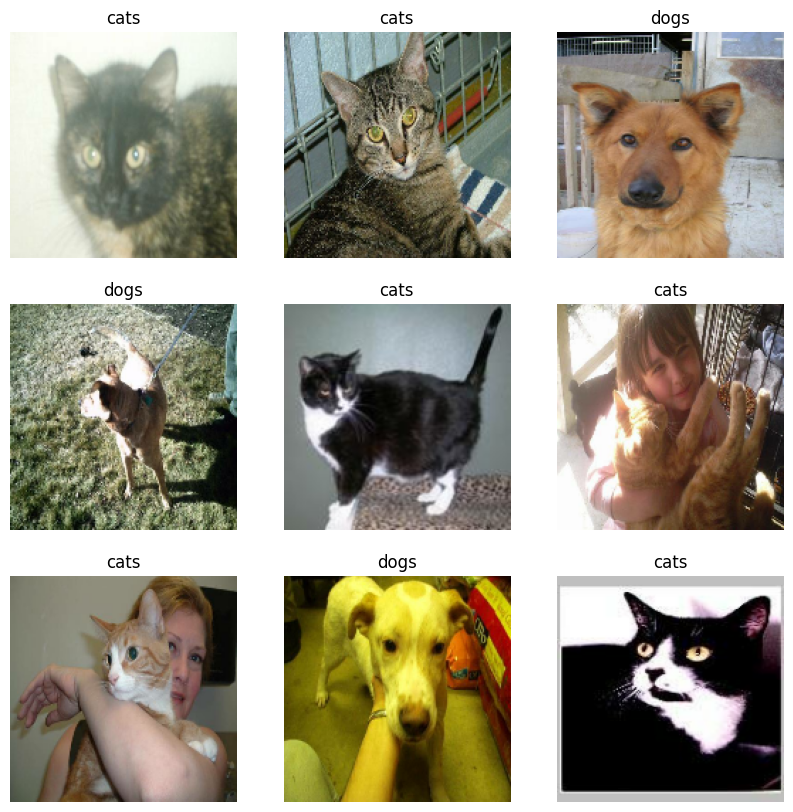

In [23]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 테스트 데이터셋 생성

In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [25]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


- **검증 데이터셋** 에서 ``20%`` 만큼 들고와 **테스트 데이터셋** 을 생성한다.

### 성능을 높이도록 데이터셋 구성

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강 사용

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### 데이터 증강 적용 이미지 시각화

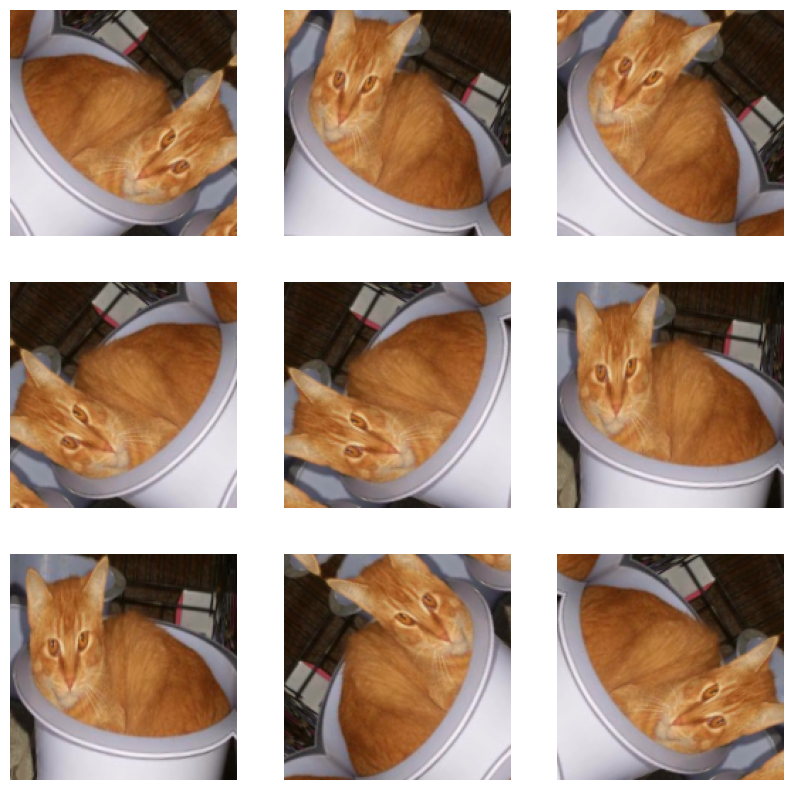

In [28]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 사전 훈련된 컨볼루션 네트워크로부터 기본 모델 생성하기

In [35]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


- ``include_top=False`` 코드로 모델의 분류 층은 제외하고 모델을 사용한다.

In [36]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


#### MobileNetV2 입력 형식 맞춤 정규화

In [34]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### 레이어를 사용한 이미지 정규화

In [33]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

- **MobileNetV2** 모델이 사용하는 픽셀 값이 ``[-1, 1]`` 이기 때문에 ``255``의 **중심값**인 ``127.5``로 나눈 후, ``-1``을 해준다.
- ``mobilenet_v2.preprocess_input`` 함수로 해당 작업을 하기 때문에 함수를 사용하면 된다.